In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn import datasets
from sklearn.metrics import silhouette_score
import plotly
import plotly.express as px

df = pd.read_csv('Sample-Superstore - Sample-Superstore.tsv', delimiter = "\t")

In [93]:
for col in df:
    df.rename(columns={col: col.lower().replace(' ', '').replace('-', '')}, inplace=True)

In [124]:
import warnings
warnings.filterwarnings('ignore')

In [125]:
df.head(2)

,rowid,orderid,orderdate,shipdate,shipmode,customerid,customername,segment,country,city,...,postalcode,region,productid,category,subcategory,productname,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


# Special categories
## Creating new categories

In [126]:
df_monetary = df.groupby('customerid')['sales'].sum()
df_monetary = df_monetary.reset_index()

In [127]:
df_frequency = df.groupby('customerid')['orderid'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['customerid', 'order_count']

In [128]:
import datetime as dt

df['orderdate'] = pd.to_datetime(df['orderdate'])

# Calculate the most recent order date
most_recent_date = df['orderdate'].max()

# Subtract the order date from the most recent date
df_recency = df.groupby('customerid')['orderdate'].max().reset_index()
df_recency['recency'] = (most_recent_date - df_recency['orderdate']).dt.days
df_recency.drop('orderdate', axis=1, inplace=True)

In [129]:
df_combined = pd.merge(df_monetary, df_frequency, on='customerid')
df_combined = pd.merge(df_combined, df_recency, on='customerid')
df_combined.head()

,customerid,sales,order_count,recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


## Box plot

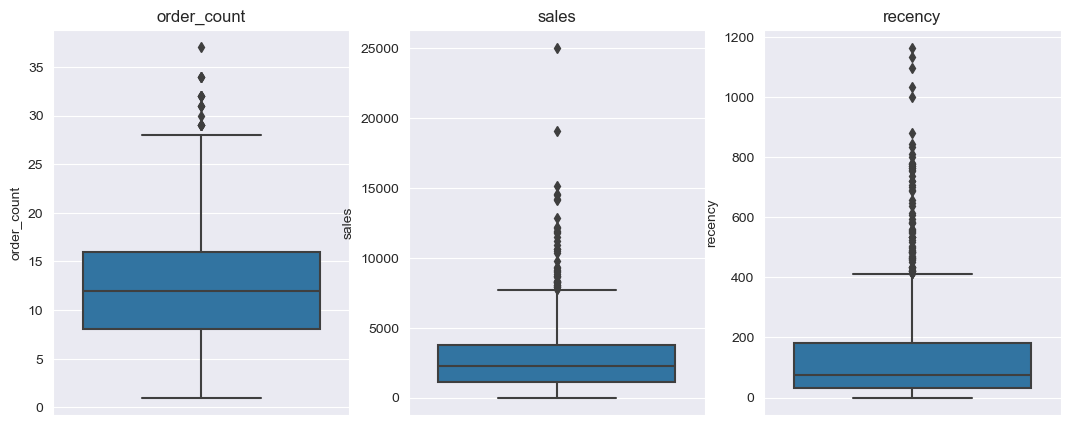

In [130]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='order_count', data=df_combined, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='sales', data=df_combined , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='recency', data=df_combined , ax=axes[2])
axes[2].set_title('recency')

plt.show()

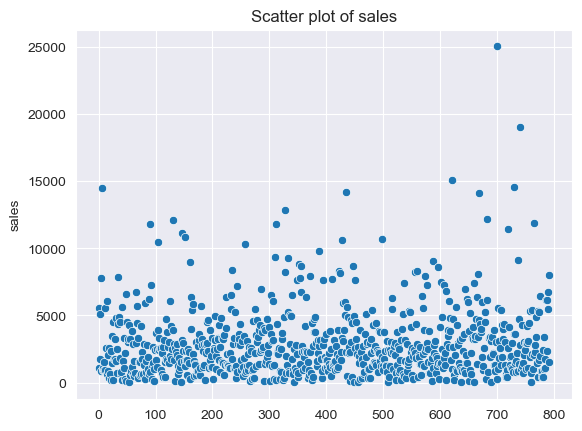

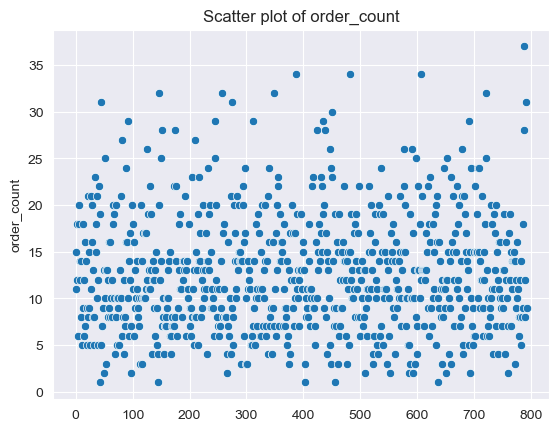

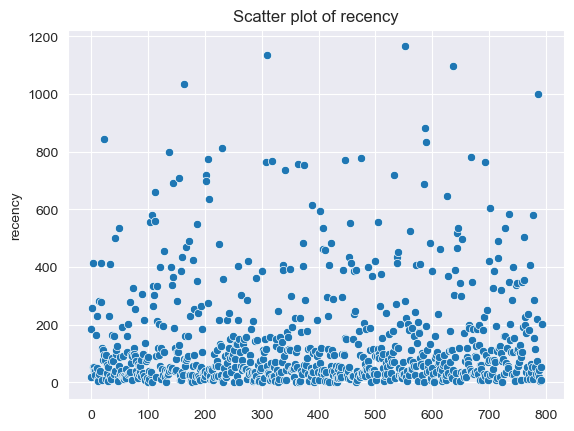

In [131]:
for column in df_combined.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_combined[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

## Remove outliers

In [132]:
q1 =df_combined.quantile(0.25)
q3 =df_combined.quantile(0.75)
iqr = q3 - q1
df_combined =df_combined[~((df_combined < (q1 - 1.5 * iqr)) |(df_combined > (q3 + 1.5 * iqr))).any(axis=1)]
print(df_combined.shape)

(668, 4)


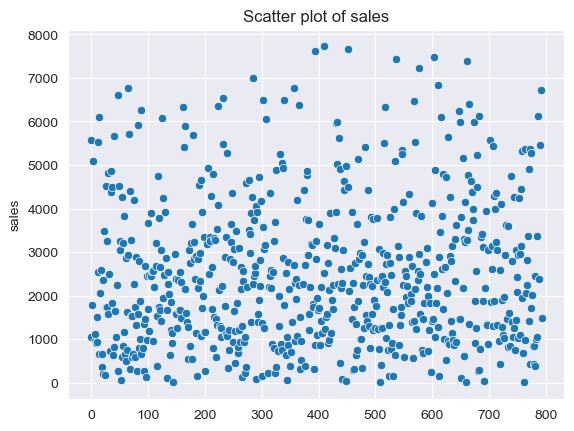

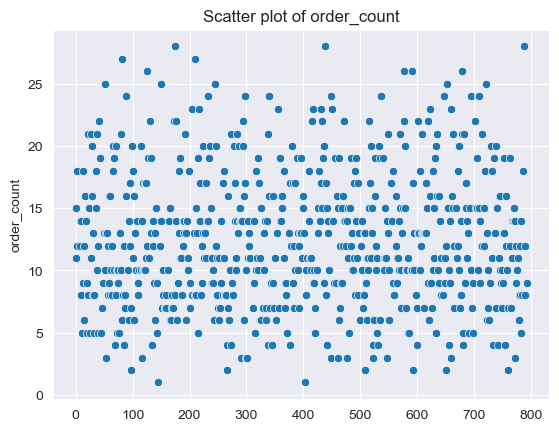

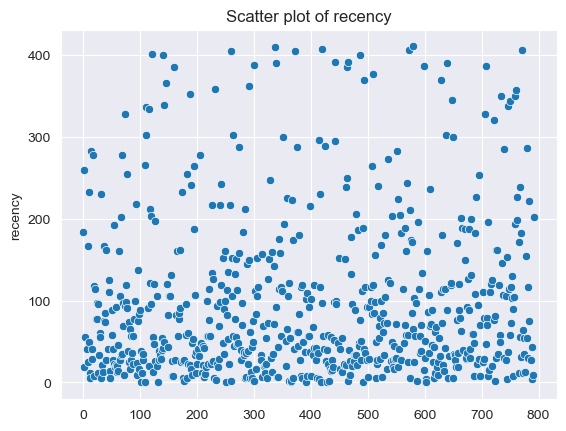

In [133]:
for column in df_combined.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_combined[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

<AxesSubplot:ylabel='recency'>

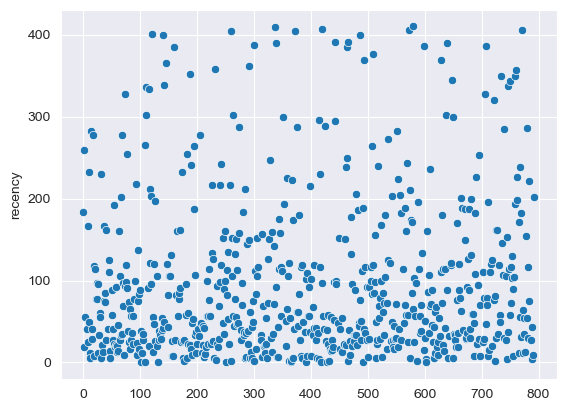

In [134]:
sns.scatterplot(data=df_combined['recency']) 

## Scaler

In [135]:
# Rescaling the attributes
rfm_df = df_combined[['sales', 'order_count', 'recency']]

scaler = StandardScaler()

# fit transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['sales', 'order_count', 'recency']
rfm_df_scaled.head()

,sales,order_count,recency
0,1.815723,-0.261677,0.876012
1,-0.863557,0.472007,-0.812704
2,-0.427160,-0.078256,1.643610
3,1.532394,1.022270,-0.444257
4,-0.916868,-0.078256,-0.587542


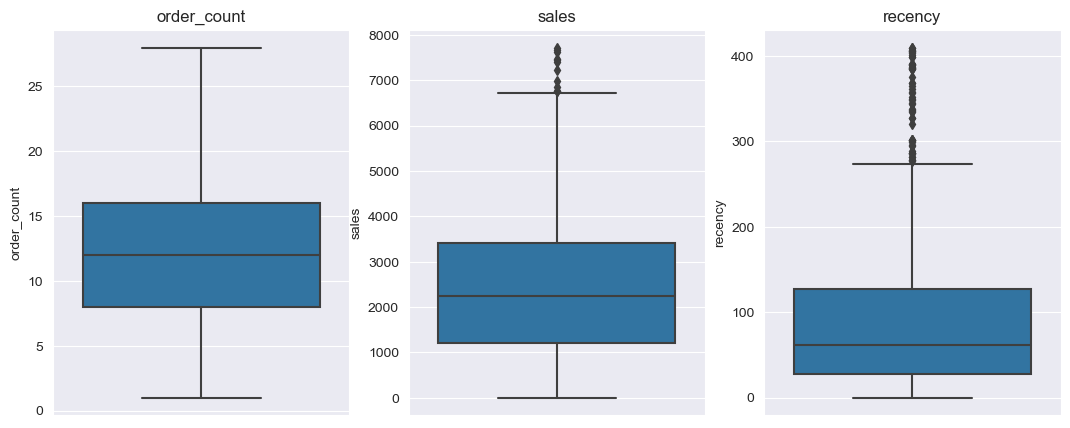

In [136]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='order_count', data=df_combined, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='sales', data=df_combined , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='recency', data=df_combined , ax=axes[2])
axes[2].set_title('recency')

plt.show()

## Finding how many clusters are needed

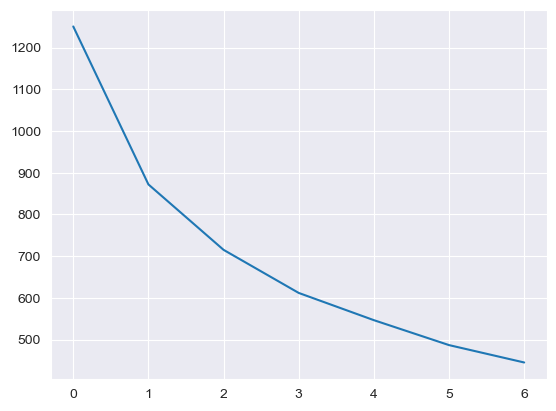

In [137]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

plt.plot(ssd)

For n_clusters=2, the silhouette score is 0.3398115200918351
For n_clusters=3, the silhouette score is 0.36305686713690394
For n_clusters=4, the silhouette score is 0.3182268144392149
For n_clusters=5, the silhouette score is 0.3213500271670719
For n_clusters=6, the silhouette score is 0.277071586702545
For n_clusters=7, the silhouette score is 0.27654097235047304
For n_clusters=8, the silhouette score is 0.2758415265852852


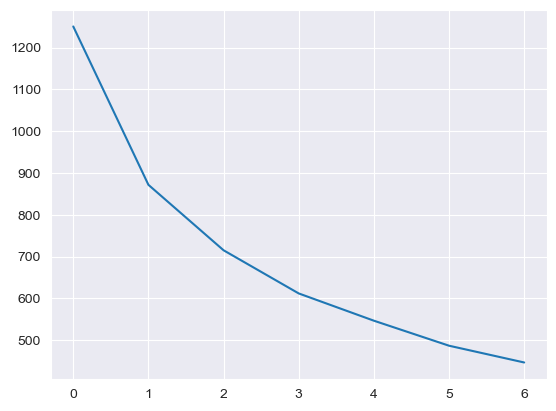

In [138]:
# Silhouette analysis
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

## Build model

In [156]:
features = rfm_df_scaled[['sales', 'order_count', 'recency']]

# Create and fit the K-means model
kmeans = KMeans(n_clusters=3)
kmeans.fit(features)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_
sorted(Counter(cluster_labels).items())

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

print("Cluster Labels:")
print(cluster_labels)
print("\nCluster Centroids:")
print(centroids)

Cluster Labels:
[0 2 1 0 2 2 2 2 1 0 0 1 0 2 1 2 2 2 0 0 2 0 2 0 2 2 0 1 2 0 0 0 2 2 2 0 0
 2 2 2 0 0 2 0 2 0 1 2 2 2 0 2 0 2 2 2 0 0 0 0 1 0 2 2 2 1 0 2 1 2 2 0 2 0
 2 2 2 2 2 0 2 2 1 2 2 2 2 2 0 2 0 2 0 0 2 2 1 1 1 2 0 1 1 0 1 2 1 0 2 0 0
 2 0 2 0 0 2 2 2 2 2 2 2 1 2 1 1 2 0 2 2 2 2 2 2 2 1 0 0 0 2 2 2 2 2 0 1 0
 0 0 2 0 0 1 0 2 2 1 2 1 0 0 0 0 1 1 0 2 2 0 2 2 2 0 2 2 0 0 2 2 2 0 0 2 0
 2 2 0 2 0 0 1 2 2 2 2 1 0 0 0 2 0 2 0 2 1 2 0 0 0 2 2 2 2 2 2 2 0 2 1 1 2
 0 2 1 2 2 2 2 0 2 2 2 0 2 1 2 0 0 0 1 2 0 1 0 0 0 2 0 0 1 0 0 0 0 2 0 0 0
 1 2 0 0 2 2 2 0 2 2 0 2 2 0 2 0 2 0 0 2 2 0 1 2 2 0 2 2 0 1 1 0 2 2 2 2 2
 0 2 2 2 1 1 0 2 0 1 2 2 2 0 0 2 1 2 2 2 1 0 1 0 0 0 0 2 0 2 2 2 0 0 2 2 2
 2 0 0 0 2 1 2 0 2 2 2 2 2 0 0 2 2 2 1 2 0 2 1 2 2 2 1 2 0 0 0 0 0 0 0 0 2
 0 0 2 2 1 1 0 0 2 0 0 0 2 0 2 0 2 2 1 1 1 1 2 2 0 0 2 0 0 2 2 2 0 2 2 1 0
 1 0 2 2 1 2 0 0 1 0 0 1 0 2 2 2 2 0 2 2 2 2 1 2 1 2 2 2 2 0 0 0 1 0 0 2 2
 2 2 0 0 2 2 2 2 1 0 0 2 0 0 2 2 1 2 2 0 2 2 0 2 1 0 1 2 1 0 1 2 2 2 1 2 2
 0 1 0 0 

## Visualize Model

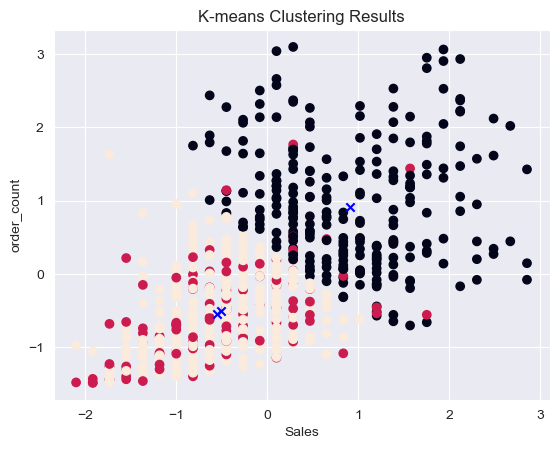

In [157]:
labels = kmeans.labels_

plt.scatter(rfm_df_scaled['order_count'], rfm_df_scaled['sales'], c=labels)
plt.scatter(centroids[:,1], centroids[:,1], marker='x', c= 'blue')
plt.xlabel('Sales')
plt.ylabel('order_count')
plt.title('K-means Clustering Results')
plt.show()

In [162]:
fig = px.scatter_3d(df_combined, x="sales", y="order_count", z="recency", color=kmeans.labels_)
fig.update_layout(autosize = True, width = 1000, height = 500)
plotly.offline.iplot(fig, filename='simple-3d-scatter')